In [1]:
import h5py
import numpy as np
import os
import pandas as pd
import scipy
import subprocess
import time

from os import listdir
from os.path import isfile, join

import matplotlib
from matplotlib import pyplot as plt

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

#matplotlib.rc('text', usetex=True)

## Load SAM data from hdf5 files

In [3]:
redshift = 0
dir_dat = '/lscratch/kstoreyf/CAMELS-SAM_data'

In [4]:
idxs_sam = [idx_sam for idx_sam in np.arange(0, 50) if isfile(f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5')]
n_sams = len(idxs_sam)

In [5]:
#fns_dat = [join(dir_dat, f) for f in listdir(dir_dat) if isfile(join(dir_dat, f))]
#idx_sam = 0
#fns_dat = [f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5']

In [6]:
#n_sams = len(fns_dat)

## Load PROVABGS data

Downloaded from https://zenodo.org/records/8018936

In [7]:
# probabilistic SMFs
fn_psmf_bgs_q = '../data/data_provabgs/psmf.sv3.bgs_bright_q.z0.01_0.05.dat'
ms, psmf_bgs_q_mean, psmf_bgs_q_std = np.loadtxt(fn_psmf_bgs_q, unpack=True)

fn_psmf_bgs_sf = '../data/data_provabgs/psmf.sv3.bgs_bright_sf.z0.01_0.05.dat'
ms, psmf_bgs_sf_mean, psmf_bgs_sf_std = np.loadtxt(fn_psmf_bgs_sf, unpack=True)

In [8]:
# combine sf and q (star-forming and quiescent)
psmf_bgs_mean = psmf_bgs_sf_mean + psmf_bgs_q_mean
psmf_bgs_std = np.sqrt(psmf_bgs_sf_std**2 + psmf_bgs_q_std**2)

In [9]:
# standard (non-probabilistic) SMF, as check
fn_smf_bgs = '../data/data_provabgs/smf.standard.sv3.bgs_bright.z0.01_0.05.dat'
ms_smf, smf_bgs = np.loadtxt(fn_smf_bgs, unpack=True)

## Plot CAMELS SMFs

In [10]:
log_mass_shift = 9
h = 0.6711 # from perez et al
print(h**3)
vol_Mpc = (100/h)**3 # 100 Mpc/h = 100/h Mpc
vol_hMpc = 100**3 # units Mpc/h!! to match bgs; diff than plotted in camels paper
print(vol_Mpc, vol_hMpc)

0.302246803431
3308554.428527777 1000000


In [11]:
edges = np.linspace(8, 12.5, 40)

bin_width = edges[1] - edges[0]                
bins_avg = edges[0:-1] + bin_width/2.           

In [12]:
smf_arr = []
for idx_sam in idxs_sam:
    fn_dat = f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5'
    with h5py.File(fn_dat, 'r') as f:
        mstar_raw = np.array(f['mstar'])
        log_mstar = np.log10(mstar_raw) + log_mass_shift
        
        phi, edges = np.histogram(log_mstar, bins=edges)   
        smf = phi / vol_Mpc / bin_width
        smf_arr.append(smf)    

/tmp/ipykernel_322536/2592971476.py:6: RuntimeWarning: divide by zero encountered in log10
  log_mstar = np.log10(mstar_raw) + log_mass_shift


In [13]:
def get_distance_sigma(x1, y1, yerr1, x2, y2, xrange):
    xmin, xmax = xrange

    y1 = y1[(x1>=xmin) & (x1<xmax)]
    yerr1 = yerr1[(x1>=xmin) & (x1<xmax)]
    y2 = y2[(x2>=xmin) & (x2<xmax)]

    x1 = x1[(x1>=xmin) & (x1<xmax)]
    x2 = x2[(x2>=xmin) & (x2<xmax)]
    
    # interpolate y2 to be at the same x-vals as x2/y2
    y2_interp = np.interp(x1, x2, y2)
    sigmas = (y2_interp - y1)/yerr1
    sigma_mean = np.mean(np.abs(sigmas))
    return sigma_mean

In [14]:
sigma_means = []
xrange = [8,11]
for i, idx_sam in enumerate(idxs_sam):
    
    sigma_mean = get_distance_sigma(ms, psmf_bgs_mean, psmf_bgs_std, bins_avg, smf_arr[i], xrange)
    sigma_means.append(sigma_mean)
sigma_means = np.array(sigma_means)

In [15]:
locs_norm = matplotlib.colors.Normalize(np.min(sigma_means), np.max(sigma_means), len(sigma_means))
cmap = matplotlib.cm.get_cmap('cool_r')
colors = cmap(locs_norm(sigma_means))

/tmp/ipykernel_322536/431812615.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('cool_r')


(8.0, 12.5)

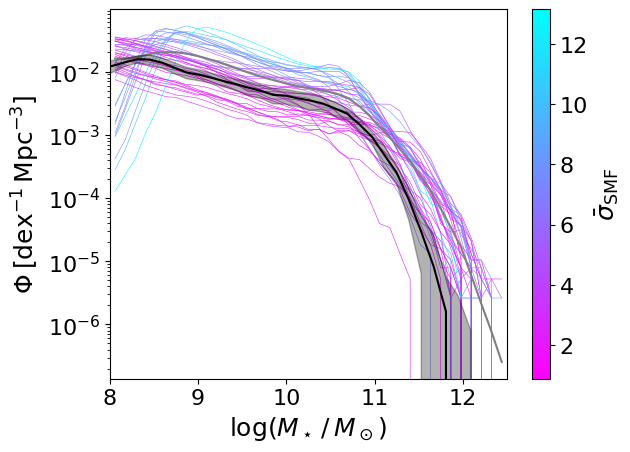

In [16]:
for i in range(n_sams):
    plt.plot(bins_avg, smf_arr[i], lw=0.4, color=colors[i])
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')

smf_mean = np.mean(smf_arr, axis=0)
smf_std = np.std(smf_arr, axis=0)
plt.plot(bins_avg, smf_mean, color='grey')
# plt.fill_between(bins_avg, 
#                  (smf_mean-smf_std), 
#                  (smf_mean+smf_std),
#                  color='magenta', alpha=0.3, lw=2,
#                  label='pSMF all')
    
plt.plot(ms, psmf_bgs_mean, color='black')
plt.fill_between(ms, 
                 psmf_bgs_mean-psmf_bgs_std, 
                 psmf_bgs_mean+psmf_bgs_std,
                 color='black', alpha=0.3,
                 zorder=10000,
                 label='BGS pSMF')
    
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')
plt.xlim(8, 12.5)

## Set up bacco P(k) code

In [17]:
pks = []
for idx_sam in idxs_sam:
    fn_pk = f'../data/pks/pk_LH_{idx_sam}.npy'
    pk = np.load(fn_pk, allow_pickle=True).item()
    pks.append(pk)

Text(0, 0.5, '$P(k)$')

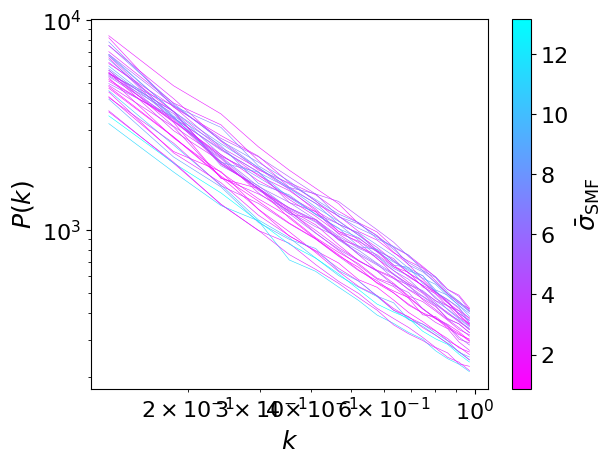

In [18]:
for i in range(n_sams):
    plt.plot(pks[i]['k'], pks[i]['pk'], lw=0.4, color=colors[i])
    
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

In [19]:
k_sam_all = pks[0]['k'] # same for all 

## Load bacco emu fits

### Fit bias params

In [34]:
bias_param_names = ['b1', 'b2', 'bs2', 'bl']
bias_param_labels = {'b1': r'$b_1$', 
                     'b2': r'$b_2$', 
                     'bs2': r'$b_{s^2}$', 
                     'bl': r'$b_{\nabla^2 \delta}$',
                    }
bias_bounds = {'b1': [-0.25, 1.75],
               'b2': [-1, 2],
               'bs2': [-3, 1],
               'bl': [-5, 2],
              } 
bias_param_names_nob1 = bias_param_names.copy()
bias_param_names_nob1.remove('b1')

Text(0.5, 0, '$b_1$')

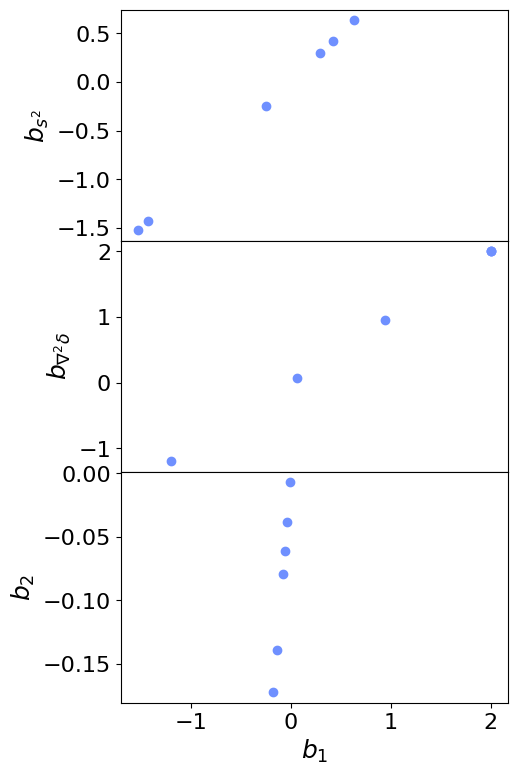

In [43]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(5, 3*nrows), sharex=True)
plt.subplots_adjust(hspace=0)

#for idx_sam in idxs_sam:
for idx_sam in idxs_sam[:6]:
    fn_bp = f'../data/bias_params_bestfit/bias_params_LH_{idx_sam}.npy'
    bias_params = np.load(fn_bp, allow_pickle=True).item()
    
    for bb, bp_name in enumerate(bias_param_names_nob1):
        axarr[bb-1].plot(bias_params[bp_name], bias_params[bp_name], marker='o', markersize=6, color=colors[i])
        axarr[bb-1].set_ylabel(bias_param_labels[bp_name])

plt.xlabel(bias_param_labels[bias_param_names[0]])